In [14]:
import datetime, os, pandas, shutil
import logging, pymysql, socket
from sqlalchemy import create_engine
import traceback
import pandas as pd
import os
import matplotlib.pyplot as plt
import pandas as pd
import shutil

drDB_SERVER_IP = "202.30.21.45"
drDB_NAME = "ensdr"

def _CheckIP():
    return socket.gethostbyname(socket.gethostname()) == drDB_SERVER_IP

def _getHostName():    
    if _CheckIP():
        return "localhost"
    else:
        return drDB_SERVER_IP
        
def connectEnsdr(user, password):
    host = _getHostName()

    try:
        conn = pymysql.connect(host = host, user = user, password = password, db = drDB_NAME, charset="utf8")
        pymysql.install_as_MySQLdb()
        engine = create_engine("mysql://"+user+":"+password+"@"+host+"/"+drDB_NAME)
        return [conn, engine]
    except:
        logging.error("Check DB info")
        logging.error("user : " + user + ", password : " + password)   
        
user_name = "jinse"
password = "es36233"

pandas.set_option('mode.chained_assignment',  None)

In [12]:
PMid_fieldName = ["PM_id","device_id","program_id","command_id"]
connEnsdr, engineEnsdr = connectEnsdr(user_name, password)

program_info = pandas.read_sql_query("SELECT * FROM event_table WHERE eventIdt='#PROGRAM' ORDER BY eventTick ASC", connEnsdr)
screenhistory_info = pandas.read_sql_query("SELECT * FROM screenhistory_table ORDER BY tick ASC", connEnsdr)
programidx_info = pandas.read_sql_query("SELECT * FROM programidx_table ORDER BY programStartTick ASC", connEnsdr)
deviceid_info = pandas.read_sql_query("SELECT * FROM deviceid_table ORDER BY device_id ASC", connEnsdr)
health_info = pandas.read_sql_query("SELECT * FROM health_table ORDER BY health_idx ASC", connEnsdr)

In [13]:
max_index = max(health_info['program_idx'])

In [10]:
programstart, programend = None, None
for i in range(len(program_info)):
    if program_info['eventNote'].iloc[i].find("ON: ") != -1:
        programstart = program_info.iloc[i]
    elif program_info['eventNote'].iloc[i].find("OFF: ") != -1 and programstart is not None:
        programend = program_info.iloc[i]
        if programstart['eventNote'].replace("ON: ","") == programend['eventNote'].replace("OFF: ",""):
            df = (screenhistory_info.loc[(screenhistory_info['tick']>=programstart['eventTick']) & (screenhistory_info['tick']<=programend['eventTick'])])
            if len(df) != 0:
                device_id = df['device_id'].iloc[0]
                match_device = deviceid_info['device_id'] == device_id
                device_name = deviceid_info[match_device]['deviceName'].iloc[0]
                program_idx = df['program_idx'].iloc[0]
                match_program = programidx_info['program_idx'] == program_idx                
                program_id = programidx_info[match_program]['program_id'].iloc[0]
                
                if program_idx > max_index: 
                    if not os.path.isdir('./screenhistory/'+ str(device_name)):
                        os.mkdir('./screenhistory/'+ str(device_name))
                    if not os.path.isdir('./screenhistory/'+ str(device_name) + '/programid_' + str(program_id)):
                        os.mkdir('./screenhistory/'+ str(device_name) + '/programid_' + str(program_id))

                    df.to_csv('./screenhistory/'+ str(device_name) +'/programid_'+ str(program_id) + '/' + str(programstart['eventTick']) + '_' + str(programend['eventTick']) + '.csv', index = False)
                    print("device_name: "+ str(device_name) + ", program_idx: " + str(program_idx))
            del df
        programstart, programend = None, None

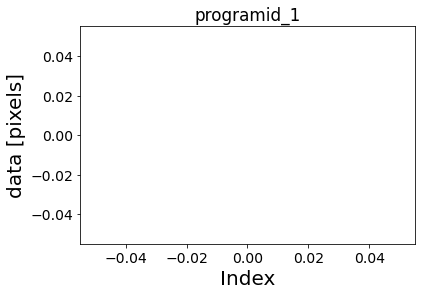

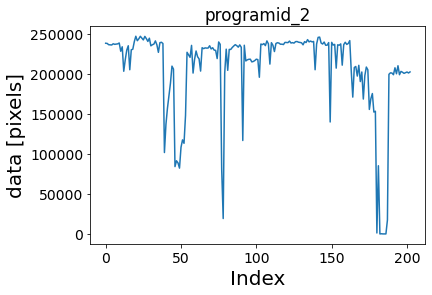

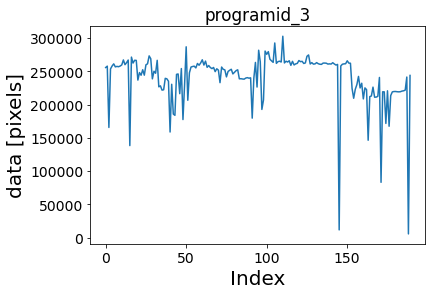

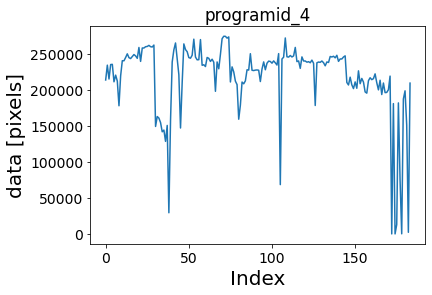

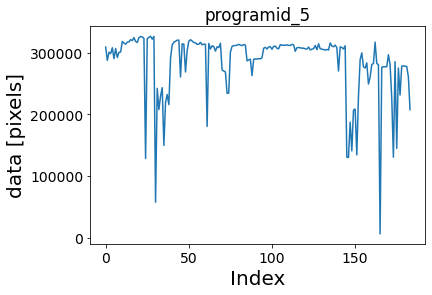

In [20]:
def ccw(x1, y1, x2, y2, x3, y3):
    temp = x1*y2 + x2*y3 + x3*y1 - y1*x2 - y2*x3 - y3*x1
    return temp

path_dir = './dist/screenhistory/N1_11001'

program_list = os.listdir(path_dir)

for i in range(len(program_list)):
    program_name = program_list[i]
    file_dir = path_dir + '/' + program_name
    file_list = os.listdir(file_dir)
    area_list = []
        
    for j in range (len(file_list)):    
        file_name = file_list[j]
        data = pd.read_csv(file_dir + '/' + file_name)

        x_data = []
        y_data = []
        N = len(data)
        ans = 0

        for k in range(N):
            x_data.append(data['coo_x'].iloc[k])
            y_data.append(data['coo_y'].iloc[k])

        for l in range(N-2):
            area = ccw(x_data[0], y_data[0], x_data[l+1], y_data[l+1], x_data[l+2], y_data[l+2])
            ans += area

        ans = abs(ans) / 2
        
        area_list.append(ans)
        src_file = path_dir + '/' +  program_name + '/' + file_name
        if not os.path.isdir('./dir/N1_11001'):
            os.mkdir('./dir/N1_11001')
        if not os.path.isdir('./dir/N1_11001/'+ program_name):
            os.mkdir('./dir/N1_11001/'+ program_name)
        dir_file = './dir/N1_11001/' + program_name + '/' + file_name
        shutil.move(src_file, dir_file)

    plt.plot(area_list)
    plt.rc('font', size=14)
    plt.rc('legend', fontsize=24)
    plt.rc('axes', labelsize=20)
    plt.title(program_name)
    plt.xlabel('Index')
    plt.ylabel('data [pixels]')

    plt.show()
    
#    df = pd.DataFrame(area_list, columns = ['data'])
#    df.to_csv("./area/" + program_name + ".csv", index=False)
#    del df


In [21]:
del program_info, screenhistory_info, programidx_info, deviceid_info
print("Done")

Done
